# Entropies of graph energies

In this experiment we are considering the entropy as the measure of [energy dispersion](https://goo.gl/qubCqh). There are multiple graph energies proposed in the literature, and in most cases the energy of a graph is defined as the sum of absolute values of eigenvalues of a particular matrix representing a graph. 

The energies computed in this experiment include:
* graph energy
* Randić energy
* Laplacian energy

Each of these energies describes a particular matrix, which in turn, expresses a different aspect of a graph. Below we present a brief overvue of each energy.

### graph energy

Graph energy of a graph is defined as $E_G(G) = \sum\limits_{i=1}^n |\mu_i|$, where $\mu_1, \ldots, \mu_n$ are the eigenvalues of the adjacency matrix $M_A$ (also known as the *spectrum* of the graph).


### Randić energy

Randić matrix of the graph $G=\left<V, E\right>$ is defined as:

$$
M_R(i,j)=
\begin{cases}
0 & \mathit{if} & i=j\\
\frac{1}{\sqrt{d_i d_j}} & \mathit{if} & (i,j) \in E\\
0 & \mathit{if} & (i,j) \notin E
\end{cases}
$$

Randić energy of a graph is defined as $E_R(G) = \sum\limits_{i=1}^n |\rho_i|$, where $\rho_1, \ldots, \rho_n$ are the eigenvalues of the Randić matrix $M_R$.

### Laplacian energy

The Laplacian matrix of the graph $G=\left<V, E\right>$ is defined as:

$$
M_L(i,j)=
\begin{cases}
d_i & \mathit{if} & i=j\\
-1 & \mathit{if} & i \neq j \; \& \; (i,j) \in E\\
0 & \mathit{otherwise} & 
\end{cases}
$$

Laplacian energy of a graph is defined as $E_L(G) = \sum\limits_{i=1}^n |\lambda_i-\frac{2m}{n}|$, where $\lambda_1, \ldots, \lambda_n$ are the eigenvalues of the Laplacian matrix $M_L$, $m=|E|$ is the number of edges, and $n=|V|$ is the number of nodes.


One can compute the energy of the entire graph, but this is of little use, since major variations may occur between different parts of the graph. In the experiment we compute local energies (energies of ego-networks for each node), thus obtaining a random variable representing all energy "states" of the graph. We then turn these into probability distributions and measure the entropy of each energy distribution. The assumption is that the entropy of energy distribution may reveal to which extent the energy is uniformly distributed across the network.

In the experiments below the following artificial network models are being used:
* Erdos-Renyi random model
* Watts-Strogatz small world model
* Waxman model
* Holme-Kim powerlaw model

For each network model we generate several instances of the model, modifying a single graph parameter. Then, we compute all the energies of all ego-networks (of radius $r=1$) and we compute the entropy of the distribution of each energy.

The gradual changes of each model are realized by modifying the following parameters:
* Erdos-Renyi random model: the probability of creating an edge between a random pair of vertices changes uniformly from $p=0.01$ to $p=1.0$, the network changes gradually from a set of isolated nodes to a clique
* Watts-Strogatz small world model: the probability of randomly rewiring an edge changes uniformly from $p=0.01$ to $p=1.0$, the network changes gradually from a strictly ordered structure where each node links to its $k=4$ nearest neighbours with no long-distance bridges to a fully random network
* Waxman model: the Waxman random graph models place $n$ nodes uniformly at random in a rectangular domain, two nodes $u,v$ are connected with an edge with probability $p = \alpha*e^{\frac{-d}{\beta*L}}$, the distance $d$ is the Euclidean distance between the nodes $u$ and $v$, $L$ is the maximum distance between all nodes in the graph. In this experiment we change $\alpha$ uniformly in the range $[0.01, 1.0]$ and $\beta=0.1$.
* Holme-Kim powerlaw model: the probability of closing a triangle after adding a random edge changes uniformly from $p=0.01$ to $p=1.0$, the resulting network is basically the same as the Albert-Barabasi model with an added triangle closure step which increases the local clustering coefficient.

In [158]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [251]:
from tqdm import tqdm
from ggplot import *

import pandas as pd
import numpy as np
import networkx as nx
import scipy, scipy.stats

from networkentropy import network_energy as ne

entropies = []
graph_properties = []

num_bins = 10
num_nodes = 100

for p in tqdm(range(1,100)):

    generators = {
        'random': nx.erdos_renyi_graph(n=num_nodes, p=p/100),
        'smallworld': nx.watts_strogatz_graph(n=num_nodes, k=4, p=p/100),
        'waxman': nx.waxman_graph(n=num_nodes, alpha=p/100, beta=0.1),
        'powerlaw': nx.powerlaw_cluster_graph(n=num_nodes, m=3, p=p/1000)
    }
    
    for generator in generators.keys():
        
        results = []
        
        G = generators[generator]
        
        node_properties = {
            'nodes': list(G.nodes),
            'degree': list(nx.degree_centrality(G).values()),
            'betweenness': list(nx.betweenness_centrality(G).values()),
            'closeness': list(nx.closeness_centrality(G).values()),
            'pagerank': list(nx.pagerank(G).values())
        }
        
        for n in G.nodes:
            g = nx.ego_graph(G=G, n=n, radius=1)

            E_randic = ne.get_randic_energy(g)
            E_graph = ne.get_graph_energy(g)
            E_laplace = ne.get_laplacian_energy(g)

            results.append((E_randic, E_graph, E_laplace))

        e_randic, e_graph, e_laplace = map(list, zip(*results))
        
        node_properties['randic_energy'] = e_randic
        node_properties['graph_energy'] = e_graph
        node_properties['laplace_energy'] = e_laplace

        graph_properties.append((p, generator, node_properties))
        
        randic_cnt, _ = np.histogram(e_randic, num_bins)
        graph_cnt, _ = np.histogram(e_graph, num_bins)
        laplace_cnt, _ = np.histogram(e_laplace, num_bins)

        randic_entropy = scipy.stats.entropy(randic_cnt)
        graph_entropy = scipy.stats.entropy(graph_cnt)
        laplace_entropy = scipy.stats.entropy(laplace_cnt)

        entropies.append((p, generator, randic_entropy, graph_entropy, laplace_entropy))

x, generator, y1, y2, y3 = map(list, zip(*entropies))

df = pd.DataFrame({'x':x, 'generator': generator, 'randic': y1, 'graph': y2, 'laplace': y3})

100%|██████████| 99/99 [06:44<00:00,  4.09s/it]


Next, we compute the correlations between several node descriptors:

* degree
* betweenness
* closeness
* pagerank
* graph energy of node neighborhood
* randić energy of node neighborhood
* laplacian energy of node neighborhood

and we we show how these correlations change as the topology of each network model undergoes a gradual change

In [252]:
graph_energy_plots = {}

for model in ['random','smallworld','powerlaw','waxman']:
    
    graph_energy_results = []

    for i in range(len(graph_properties)):
        dfx = pd.DataFrame(graph_properties[i][2]).corr()
        res = dfx['graph_energy']
        res['p'] = graph_properties[i][0]
        res['model'] = graph_properties[i][1]
        graph_energy_results.append(res)

    df_graph_energy = pd.DataFrame(graph_energy_results).dropna()

    df_graph_energy_melted = pd.melt(df_graph_energy, 
                                    id_vars=['p','model'], 
                                    value_vars=['degree',
                                                'betweenness',
                                                'closeness',
                                                'pagerank',
                                                'randic_energy',
                                                'laplace_energy'])

    plot = ggplot(aes(x='p', y='value', color='variable'), 
           data=df_graph_energy_melted[df_graph_energy_melted['model'] == model]) + \
        geom_line() + \
        facet_wrap('variable') + \
        ggtitle('Correlation of graph energy with other node descriptors') + \
        ylab('Pearson correlation coefficient')
        
    graph_energy_plots[model] = plot

In [253]:
randic_energy_plots = {}

for model in ['random','smallworld','powerlaw','waxman']:
    
    randic_energy_results = []

    for i in range(len(graph_properties)):
        dfx = pd.DataFrame(graph_properties[i][2]).corr()
        res = dfx['randic_energy']
        res['p'] = graph_properties[i][0]
        res['model'] = graph_properties[i][1]
        randic_energy_results.append(res)

    df_randic_energy = pd.DataFrame(randic_energy_results).dropna()

    df_randic_energy_melted = pd.melt(df_randic_energy, 
                                    id_vars=['p','model'], 
                                    value_vars=['degree',
                                                'betweenness',
                                                'closeness',
                                                'pagerank',
                                                'graph_energy',
                                                'laplace_energy'])

    plot = ggplot(aes(x='p', y='value', color='variable'), 
           data=df_randic_energy_melted[df_randic_energy_melted['model'] == model]) + \
    geom_line() + \
    facet_wrap('variable') + \
    ggtitle('Correlation of Randić energy with other node descriptors') + \
    ylab('Pearson correlation coefficient')
    
    randic_energy_plots[model] = plot

In [254]:
laplace_energy_plots = {}

for model in ['random','smallworld','powerlaw','waxman']:

    laplace_energy_results = []

    for i in range(len(graph_properties)):
        dfx = pd.DataFrame(graph_properties[i][2]).corr()
        res = dfx['laplace_energy']
        res['p'] = graph_properties[i][0]
        res['model'] = graph_properties[i][1]
        laplace_energy_results.append(res)

    df_laplace_energy = pd.DataFrame(laplace_energy_results).dropna()

    df_laplace_energy_melted = pd.melt(df_laplace_energy, 
                                    id_vars=['p','model'], 
                                    value_vars=['degree',
                                                'betweenness',
                                                'closeness',
                                                'pagerank',
                                                'graph_energy',
                                                'randic_energy'])

    plot = ggplot(aes(x='p', y='value', color='variable'), 
            data=df_laplace_energy_melted[df_laplace_energy_melted['model'] == model]) + \
        geom_line() + \
        facet_wrap('variable') + \
        ggtitle('Correlation of Laplace energy with other node descriptors') + \
        ylab('Pearson correlation coefficient')

    laplace_energy_plots[model] = plot

#### Erdos-Renyi random model

Below we present the correlations of energies with other node descriptors. Our observations are as follows:

* **graph energy** correlates strongly with closeness and pagerank, even for relatively low probability of random edge creation (20%), in these networks there is enough connectivity between nodes to produce large connected components, but the networks are far from being cliques
* **randić energy** correlates well with the betweenness, one can investigate the possibility of estimating the betweenness of a node based on its randić energy for a wide spectrum of random networks
* **laplacian energy** correlates almost perfectly with degree, pagerank and closeness, since both pagerank and closeness are costly to compute, one can estimate these values based on the laplacian energy of a node

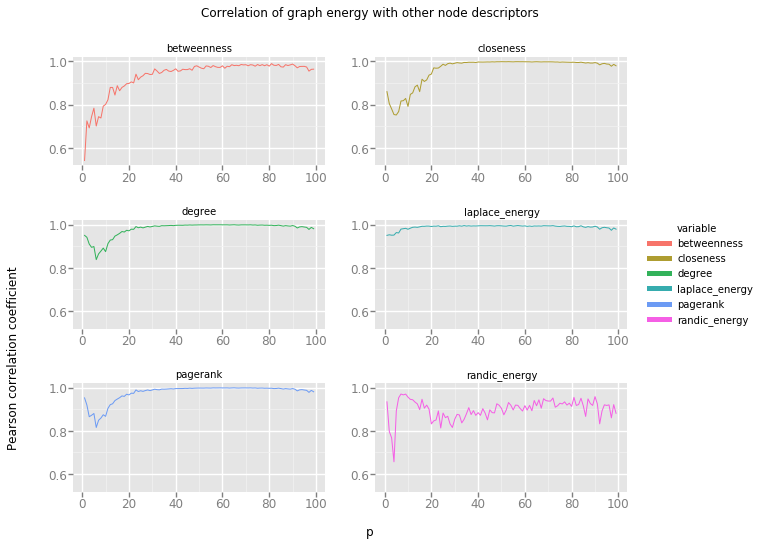

<ggplot: (-9223363243129515092)>

In [255]:
graph_energy_plots['random']

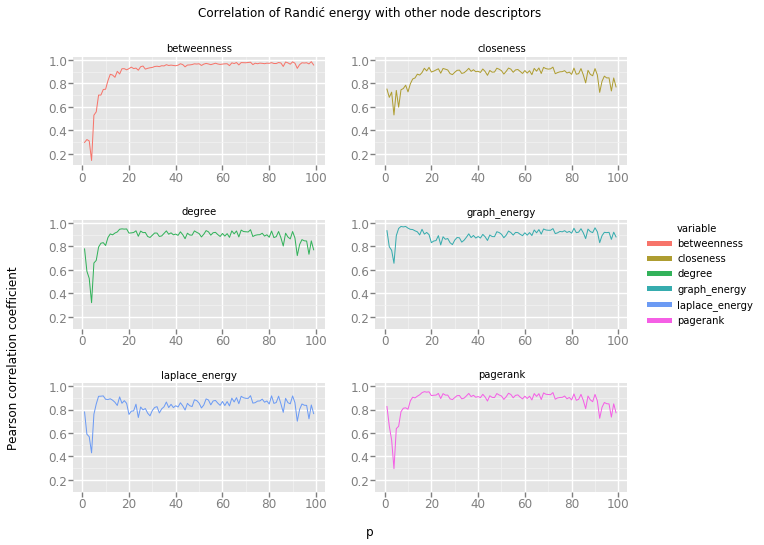

<ggplot: (-9223363243121814654)>

In [256]:
randic_energy_plots['random']

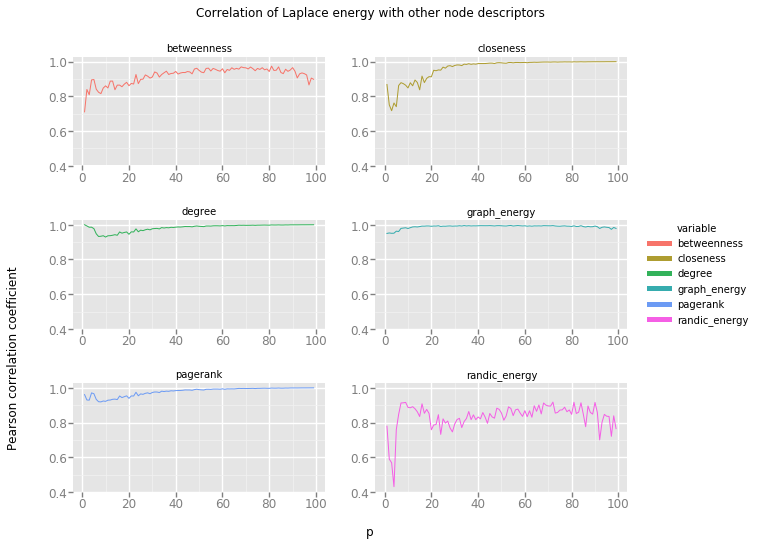

<ggplot: (8793727811441)>

In [257]:
laplace_energy_plots['random']

#### Watts-Strogatz small world model

Below we present the correlations of energies with other node descriptors. Our observations are as follows:

* **graph energy** correlates only with laplacian energy, there is some correlation with degree and pagerank, but most probably this correlation is too weak to provide accurate estimates
* **randić energy** cannot be reasonably used to provide any estimates regarding the properties of nodes in small world networks
* **laplacian energy** correlates to some extent with degree and pagerank, providing means for estimation, but this can be achieved only when the probability of edge rewiring is significant

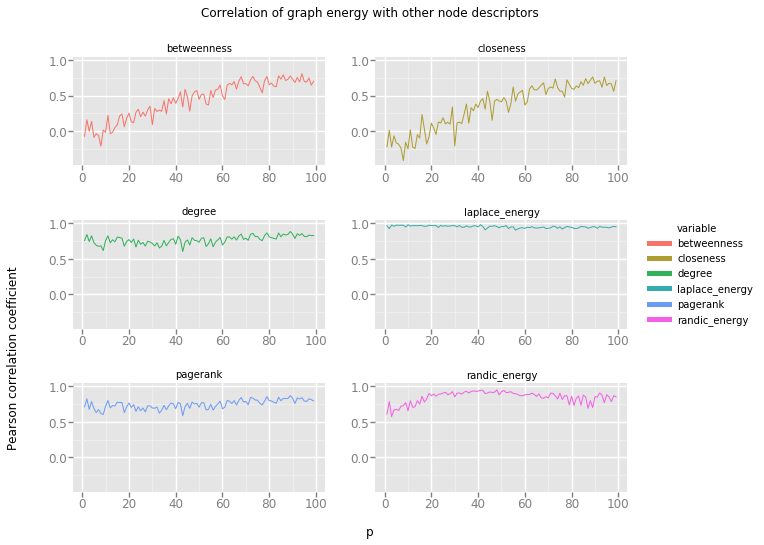

<ggplot: (-9223363243126664753)>

In [258]:
graph_energy_plots['smallworld']

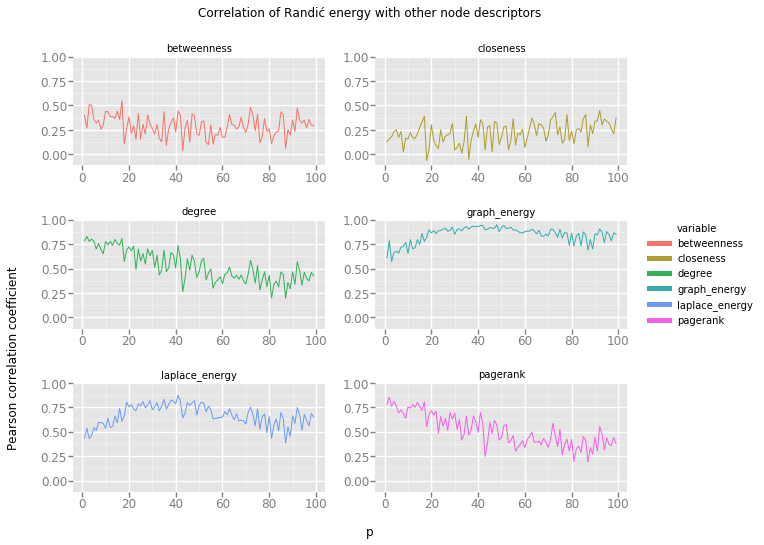

<ggplot: (-9223363243121195923)>

In [259]:
randic_energy_plots['smallworld']

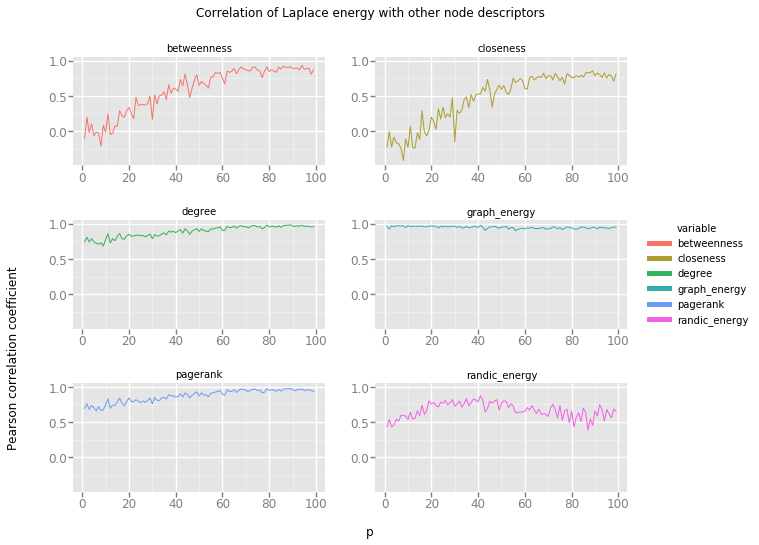

<ggplot: (8793725943644)>

In [260]:
laplace_energy_plots['smallworld']

#### Waxman random model

Below we present the correlations of energies with other node descriptors. Our observations are as follows:

* **graph energy** correlates with degree and pagerank for small values of $\alpha$ and $\beta$ parameters of the model
* **randić energy** again does not seem to be very useful for estimating the values of other node descriptors
* **laplacian energy** correlates very strongly with degree, and somehow strongly with pagerank

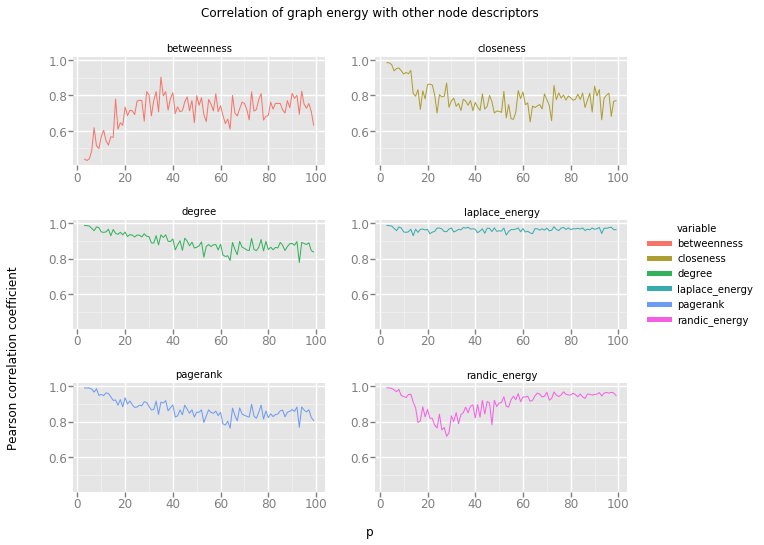

<ggplot: (8793726067299)>

In [261]:
graph_energy_plots['waxman']

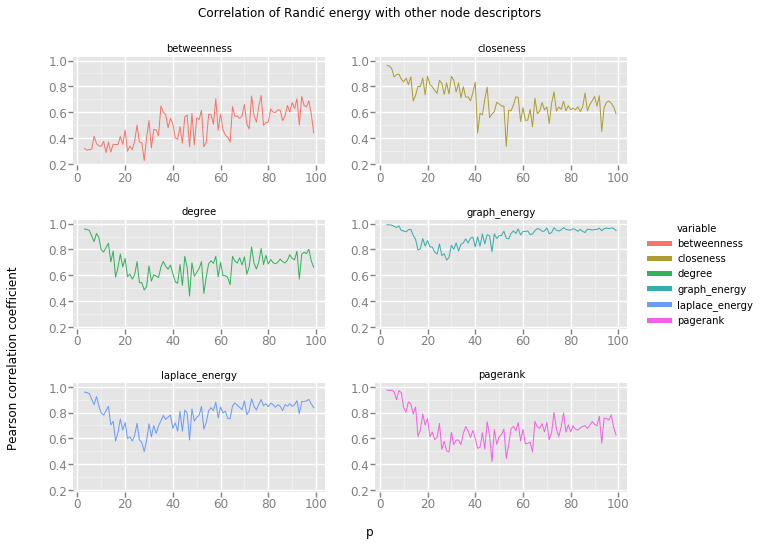

<ggplot: (-9223363243130130863)>

In [262]:
randic_energy_plots['waxman']

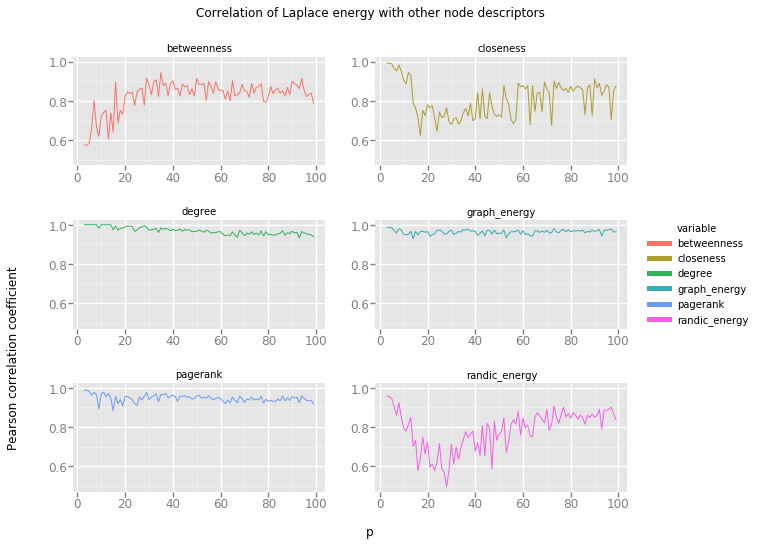

<ggplot: (8793724796294)>

In [263]:
laplace_energy_plots['waxman']

#### Holme-Kim powerlaw model

Below we present the correlations of energies with other node descriptors. Our observations are as follows:

* **graph energy** correlates with betweenness, degree and powerlaw to the extent that allows us to suspect that it is possible to estimate these descriptors based on the graph energy of the node
* **randić energy** correlates well with other types of node energies, but the correlations with degree, pagerank and betweenness are significant and can be useful
* **laplacian energy** exhibits very strong correlation with degree, betweenness and pagerank

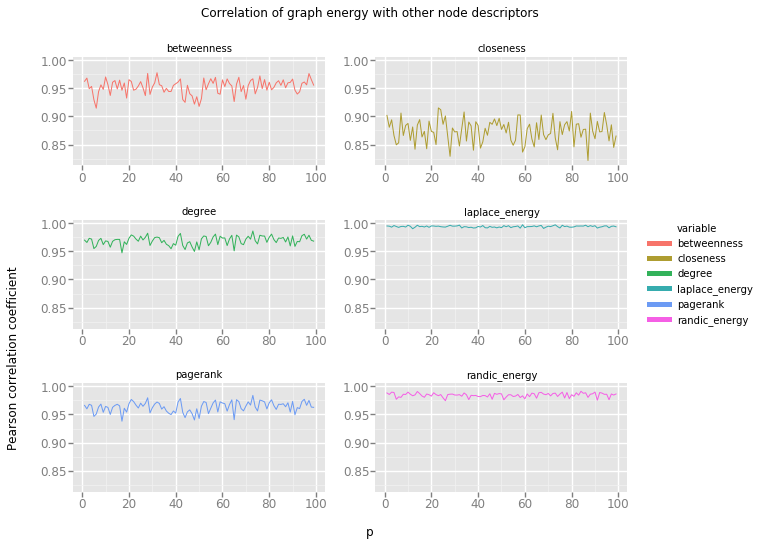

<ggplot: (8793738325431)>

In [227]:
graph_energy_plots['powerlaw']

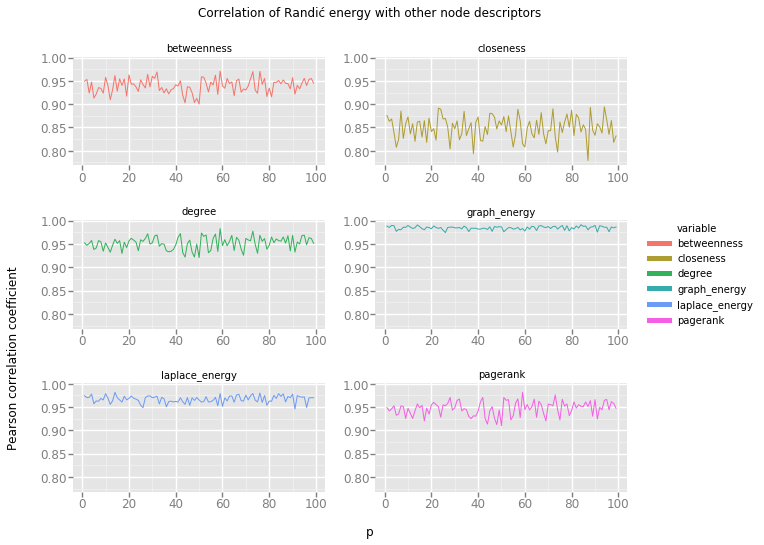

<ggplot: (8793732751487)>

In [228]:
randic_energy_plots['powerlaw']

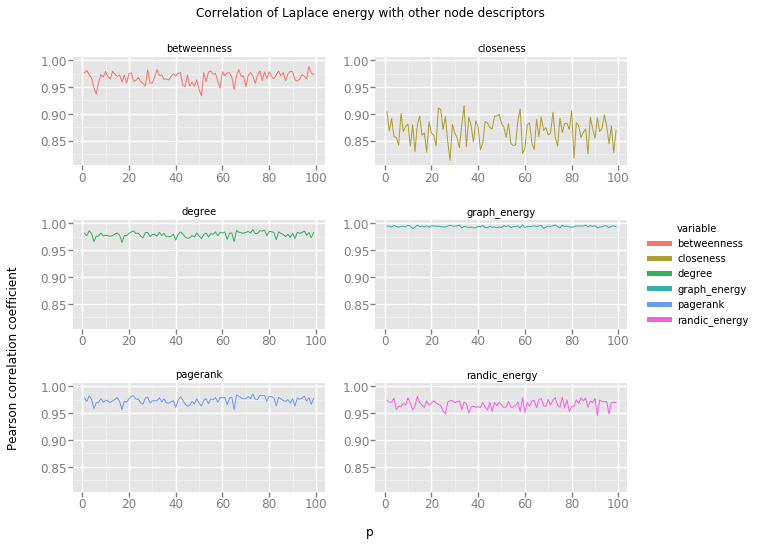

<ggplot: (8793745336268)>

In [229]:
laplace_energy_plots['powerlaw']

In [230]:
dfm = pd.melt(df, id_vars=['x','generator'], value_vars=['graph','laplace','randic'])

## Results

Below we present the preliminary results. Not only does the entropy change for each graph model, but there are visible differences between the models as well.

1. **Powerlaw graph model** : when the probability of triad closure in the powerlaw graph model is low, the entropy tends to increase, but after reaching a certain saturation point the entropy of most energies begins to steadily decrease 

2. **Random graph model** : entropies of all energies quickly increase and stay at the maximum level during the densification of the graph, when the edge probability creation reaches 1 (leading to a large clique), the entropies drop.

3. **Small world**: we begin with a regular small world lattice and gradually increase the probability of edge rewiring. Interestingly, the addition of random edges affects the entropies only at the beginning, but after a certain threshold the entropy begins to diminish

4. **Waxman**: the behavior of entropies is very similar to the small world network, despite the fact that the generative model is significantly different.

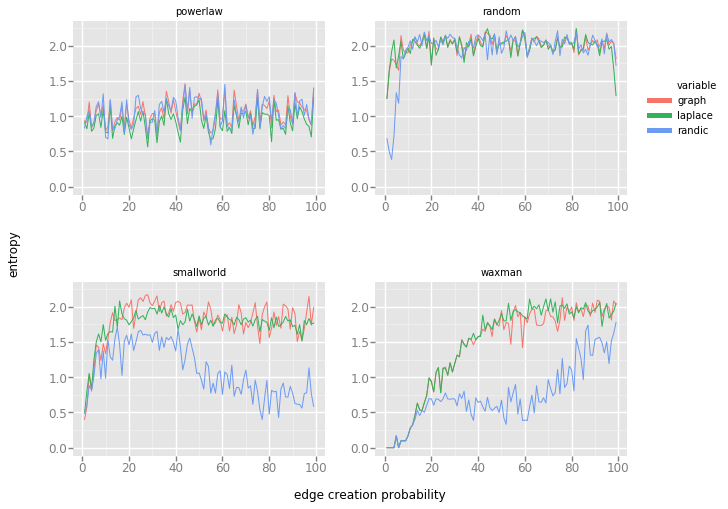

<ggplot: (8793737230526)>

In [232]:
ggplot(aes(x='x', y='value', color='variable'), data=dfm) + \
geom_line() + \
facet_wrap('generator') + \
ylab('entropy') + \
xlab('edge creation probability')